<a href="https://colab.research.google.com/github/HARIScyber/TimeSeriesScientist-AI-Agent-for-Time-Series-Analysis/blob/main/A_General_Purpose_AI_Agent_for_Time_Series_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

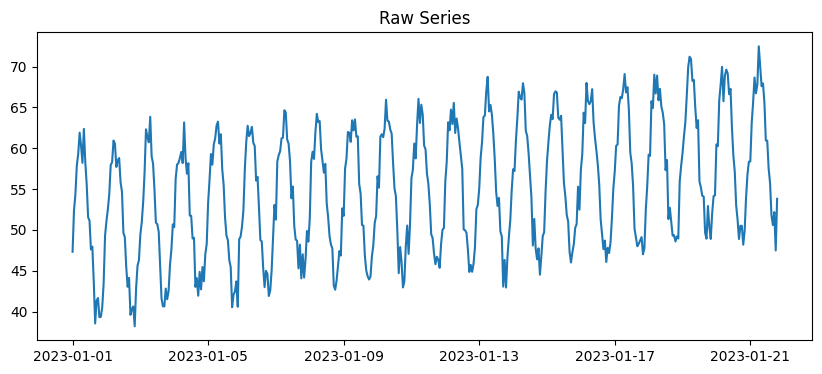


Planner selected candidates: ['VAR', 'MV_LSTM', 'ARIMA']

========== TSci REPORT ==========

Input summary:
{
  "count": 500,
  "missing": 0,
  "mean": 55.066028167020036,
  "std": 7.810812284266736,
  "trend_slope": 0.01920205063623523
}

LLM advice (curator):
Use interpolation for missing values and winsorization for outliers.

Planner selected candidates:
 - VAR | val_mae=5.9744
 - MV_LSTM | val_mae=55.9671
 - ARIMA | val_mae=10.0174

Ensemble weights:
  VAR: 0.587
  MV_LSTM: 0.063
  ARIMA: 0.350


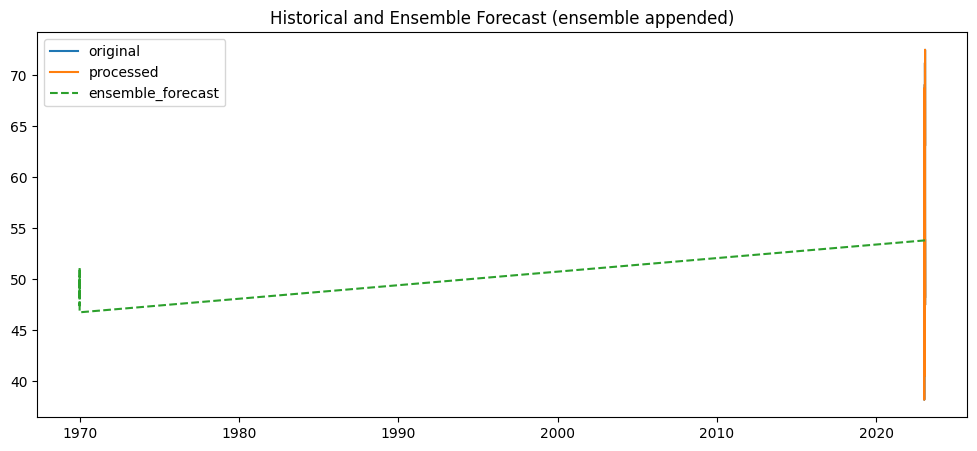

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import VAR

# Optional TensorFlow
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    TF_AVAILABLE = True
except Exception:
    TF_AVAILABLE = False


# =========================================================
# LLM INTERFACE
# =========================================================
class LLMInterface:
    def call(self, prompt, max_tokens=512):
        lower = prompt.lower()
        if "missing" in lower or "outlier" in lower:
            return "Use interpolation for missing values and winsorization for outliers."
        if "trend" in lower:
            return "Detected trend — recommend ARIMA/ETS family models."
        if "ensemble" in lower:
            return "Use inverse-MAE weighted ensemble."
        return "Use ensemble of best models."


# =========================================================
# CROSS CORRELATION AGENT
# =========================================================
class CrossCorrelationAgent:
    def __init__(self, max_lag=24):
        self.max_lag = max_lag

    def analyze(self, df, target_col):
        results = {}
        for col in df.columns:
            if col == target_col:
                continue

            corrs = []
            for lag in range(1, self.max_lag + 1):
                corr = df[target_col].corr(df[col].shift(lag))
                corrs.append(corr)

            best_lag = int(np.argmax(np.abs(corrs)) + 1)
            best_corr = float(corrs[best_lag - 1])
            results[col] = {"best_lag": best_lag, "correlation": best_corr}

        return results


# =========================================================
# CURATOR
# =========================================================
class Curator:
    def __init__(self, llm=None):
        self.llm = llm or LLMInterface()

    def diagnose(self, data, target_col=None, visualize=True):
        if isinstance(data, pd.Series):
            series = data
            df = pd.DataFrame({"target": data})
            target_col = "target"
        else:
            df = data.copy()
            series = df[target_col]

        s = series.dropna()

        stats = {
            "count": int(series.count()),
            "missing": int(series.isna().sum()),
            "mean": float(s.mean()),
            "std": float(s.std()),
        }

        # trend slope
        try:
            idx = np.arange(len(s))
            stats["trend_slope"] = float(np.polyfit(idx, s.values, 1)[0])
        except:
            stats["trend_slope"] = None

        # cross correlation if multivariate
        cross_corr = None
        if isinstance(data, pd.DataFrame) and len(data.columns) > 1:
            cca = CrossCorrelationAgent()
            cross_corr = cca.analyze(df, target_col)

        prompt = f"Stats: {json.dumps(stats)}"
        llm_advice = self.llm.call(prompt)

        summary = {
            "stats": stats,
            "cross_correlation": cross_corr,
            "llm_advice": llm_advice,
        }

        if visualize:
            plt.figure(figsize=(10, 4))
            plt.plot(series.index, series.values)
            plt.title("Raw Series")
            plt.show()

        return summary

    def preprocess(self, series):
        s = series.interpolate().ffill().bfill()
        q1, q99 = s.quantile(0.01), s.quantile(0.99)
        return s.clip(q1, q99)


# =========================================================
# HELPERS
# =========================================================
def make_lag_features(series, lags=6):
    df = pd.DataFrame({"y": series.values})
    for i in range(1, lags + 1):
        df[f"lag_{i}"] = df["y"].shift(i)
    df = df.dropna()
    return df.drop("y", axis=1).values, df["y"].values


def iterative_forecast_rf(model, train_series, horizon, lags):
    hist = list(train_series.values)
    preds = []
    for _ in range(horizon):
        feat = np.array([hist[-i] for i in range(1, lags + 1)]).reshape(1, -1)
        p = model.predict(feat)[0]
        preds.append(p)
        hist.append(p)
    return np.array(preds)


# =========================================================
# MULTIVARIATE LSTM
# =========================================================
def create_mv_sequences(data, window=24):
    X, y = [], []
    # The LSTM predicts the target column, which is assumed to be the first column (index 0)
    for i in range(len(data) - window):
        X.append(data[i : i + window])
        y.append(data[i + window, 0]) # Predicts the first column
    return np.array(X), np.array(y)


def build_mv_lstm(n_features, window):
    model = Sequential(
        [
            LSTM(64, input_shape=(window, n_features)),
            Dense(1),
        ]
    )
    model.compile(optimizer="adam", loss="mse")
    return model

def iterative_forecast_lstm(model, train_series_df, horizon, window, target_col_idx=0):
    """
    Iterative forecasting using trained LSTM model.
    `model` expects input of shape (1, window, n_features).
    `train_series_df` is a DataFrame.
    `target_col_idx`: index of the target column in the DataFrame.
    """
    # Create a copy of the values to avoid modifying the original DataFrame's underlying data
    history = train_series_df.values.tolist()
    preds = []
    n_features = train_series_df.shape[1]

    for _ in range(horizon):
        # Take the last 'window' observations
        input_sequence = np.array(history[-window:]).reshape(1, window, n_features)
        # Predict the next step (target_col only)
        # verbose=0 to suppress Keras output for each prediction
        next_pred = model.predict(input_sequence, verbose=0)[0, 0]
        preds.append(next_pred)

        # Create new row for history: predicted target, and last known exogenous values
        new_row = [0.0] * n_features
        new_row[target_col_idx] = next_pred # Set predicted target

        # For exogenous features, assume they are carried forward from the last known actual values.
        # This is a common simplification when future exogenous values are unknown.
        for i in range(n_features):
            if i != target_col_idx:
                new_row[i] = history[-1][i]
        history.append(new_row)
    return np.array(preds)


# =========================================================
# PLANNER
# =========================================================
class Planner:
    def __init__(self, llm=None, target_col=None):
        self.llm = llm or LLMInterface()
        self.model_pool = ["ARIMA", "ETS", "LGBM", "VAR", "MV_LSTM"]
        self.target_col = target_col

    def choose_candidates(self, analysis_summary, top_k=3):
        stats = analysis_summary["stats"]
        cross = analysis_summary.get("cross_correlation")

        candidates = []

        if cross is not None and self.target_col:
            candidates += ["VAR", "MV_LSTM"]

        if abs(stats.get("trend_slope", 0)) > 0.001:
            candidates += ["ARIMA", "ETS"]
        else:
            candidates += ["LGBM", "ARIMA"]

        # dedupe
        seen, ordered = set(), []
        for m in candidates:
            if m not in seen:
                ordered.append(m)
                seen.add(m)
            if len(ordered) >= top_k:
                break

        return ordered

    def hyperparam_search(self, model_name, train_series, val_series, target_col=None):
        best = {"val_mae": float("inf")}

        # Determine the series to use for univariate models
        current_target_col = target_col if target_col else (train_series.name if isinstance(train_series, pd.Series) else None)
        if isinstance(train_series, pd.DataFrame) and current_target_col:
            train_uni = train_series[current_target_col]
            val_uni = val_series[current_target_col]
        else:
            train_uni = train_series
            val_uni = val_series


        # ================= ARIMA =================
        if model_name == "ARIMA":
            try:
                model = ARIMA(train_uni, order=(1, 1, 1)).fit()
                preds = model.forecast(len(val_uni))
                mae = mean_absolute_error(val_uni, preds)
                best = {"model": model, "val_mae": mae, "params": {}}
            except Exception as e:
                pass

        # ================= ETS =================
        elif model_name == "ETS":
            try:
                model = ExponentialSmoothing(train_uni, trend="add").fit()
                preds = model.forecast(len(val_uni))
                mae = mean_absolute_error(val_uni, preds)
                best = {"model": model, "val_mae": mae, "params": {}}
            except Exception as e:
                pass

        # ================= LGBM (RF proxy) =================
        elif model_name == "LGBM":
            lags = 6
            # Use univariate series for make_lag_features
            X_train, y_train = make_lag_features(train_uni, lags)
            X_val, y_val = make_lag_features(
                pd.concat([train_uni.tail(lags), val_uni]), lags
            )
            rf = RandomForestRegressor(n_estimators=50)
            rf.fit(X_train, y_train)
            preds = rf.predict(X_val)
            mae = mean_absolute_error(y_val, preds)
            best = {"model": rf, "val_mae": mae, "params": {"lags": lags}}

        # ================= VAR =================
        elif model_name == "VAR" and isinstance(train_series, pd.DataFrame):
            try:
                model = VAR(train_series).fit(maxlags=5)
                preds = model.forecast(train_series.values[-model.k_ar :], len(val_series))
                # For MAE, we need to compare only the target column's predictions
                val_target_col_idx = val_series.columns.get_loc(self.target_col) if self.target_col else 0
                mae = mean_absolute_error(val_series.iloc[:, val_target_col_idx], preds[:, val_target_col_idx])
                best = {"model": model, "val_mae": mae, "params": {}}
            except Exception as e:
                pass

        # ================= MV LSTM =================
        elif model_name == "MV_LSTM" and TF_AVAILABLE and isinstance(train_series, pd.DataFrame):
            try:
                window = 24
                X_train, y_train = create_mv_sequences(train_series.values, window)
                X_val, y_val = create_mv_sequences(val_series.values, window)

                model = build_mv_lstm(train_series.shape[1], window)
                model.fit(X_train, y_train, epochs=3, verbose=0)

                preds = model.predict(X_val, verbose=0).flatten()
                mae = mean_absolute_error(y_val, preds)
                best = {"model": model, "val_mae": mae, "params": {"window": window}}
            except Exception as e:
                pass

        return best


# =========================================================
# FORECASTER
# =========================================================
class Forecaster:
    def __init__(self, llm=None, target_col=None):
        self.llm = llm or LLMInterface()
        self.target_col = target_col

    def ensemble_and_forecast(self, models_info, train_series, horizon):
        per_model_preds = {}
        val_scores = []

        # Determine target column index if train_series is a DataFrame
        target_col_idx = 0
        if isinstance(train_series, pd.DataFrame) and self.target_col:
            target_col_idx = train_series.columns.get_loc(self.target_col)


        for info in models_info:
            name = info["name"]
            model = info["model"]

            try:
                if name in ["ARIMA", "ETS"]:
                    preds = model.forecast(horizon)
                elif name == "VAR":
                    preds = model.forecast(train_series.values[-model.k_ar :], horizon)[:, target_col_idx]
                elif name == "LGBM":
                    series_for_rf = train_series.iloc[:, target_col_idx] if isinstance(train_series, pd.DataFrame) else train_series
                    preds = iterative_forecast_rf(
                        model, series_for_rf, horizon, info["params"]["lags"]
                    )
                elif name == "MV_LSTM":
                    window = info["params"].get("window", 24)
                    preds = iterative_forecast_lstm(
                        model, train_series, horizon, window, target_col_idx
                    )
                else:
                    if isinstance(train_series, pd.DataFrame):
                        last_val = train_series.iloc[-1, target_col_idx]
                    else:
                        last_val = train_series.iloc[-1]
                    preds = np.repeat(last_val, horizon)
            except Exception as e:
                if isinstance(train_series, pd.DataFrame):
                    last_val = train_series.iloc[-1, target_col_idx]
                else:
                    last_val = train_series.iloc[-1]
                preds = np.repeat(last_val, horizon)

            per_model_preds[name] = np.array(preds)
            val_scores.append(info["val_mae"])

        inv = 1 / np.maximum(val_scores, 1e-6)
        weights = inv / inv.sum()

        names = list(per_model_preds.keys())
        stack = np.vstack([per_model_preds[n] for n in names])
        ensemble = np.dot(weights, stack)

        return ensemble, per_model_preds, dict(zip(names, weights))


# =========================================================
# REPORTER
# =========================================================
class Reporter:
    def generate_report(
        self,
        original_series,
        processed_series,
        analysis_summary,
        candidates_info,
        ensemble_forecast,
        weights,
        horizon,
    ):
        print("\n========== TSci REPORT ==========")
        print("\nInput summary:")
        print(json.dumps(analysis_summary["stats"], indent=2))

        print("\nLLM advice (curator):")
        print(analysis_summary["llm_advice"])

        print("\nPlanner selected candidates:")
        for c in candidates_info:
            print(f" - {c['name']} | val_mae={c['val_mae']:.4f}")

        print("\nEnsemble weights:")
        for k, v in weights.items():
            print(f"  {k}: {v:.3f}")

        # plot
        plt.figure(figsize=(12, 5))
        plt.plot(original_series.index, original_series.values, label="original")
        plt.plot(processed_series.index, processed_series.values, label="processed")

        future_index = pd.RangeIndex(
            start=len(processed_series),
            stop=len(processed_series) + horizon,
        )

        plt.plot(
            list(processed_series.index)[-1:] + list(future_index),
            np.concatenate([[processed_series.iloc[-1]], ensemble_forecast]),
            label="ensemble_forecast",
            linestyle="--",
        )

        plt.title("Historical and Ensemble Forecast (ensemble appended)")
        plt.legend()
        plt.show()


# =========================================================
# PIPELINE
# =========================================================
def run_tsci_pipeline(data, target_col=None, horizon=24):
    llm = LLMInterface()
    curator = Curator(llm)
    planner = Planner(llm, target_col=target_col)
    forecaster = Forecaster(llm, target_col=target_col)
    reporter = Reporter()

    analysis = curator.diagnose(data, target_col)

    if isinstance(data, pd.Series):
        processed = curator.preprocess(data)
    else:
        processed = data.fillna(method="ffill").fillna(method="bfill")

    N = len(processed)
    val_len = horizon
    test_len = horizon

    train = processed.iloc[: N - val_len - test_len]
    val = processed.iloc[N - val_len - test_len : N - test_len]

    candidates = planner.choose_candidates(analysis)
    print("\nPlanner selected candidates:", candidates)

    candidates_info = []
    for name in candidates:
        best = planner.hyperparam_search(name, train, val, target_col)
        if "model" in best:
            best["name"] = name
            candidates_info.append(best)

    ensemble, per_model_preds, weights = forecaster.ensemble_and_forecast(
        candidates_info, train, horizon
    )

    if isinstance(processed, pd.DataFrame):
        original_series = processed.iloc[:, 0]
        processed_series = processed.iloc[:, 0]
    else:
        original_series = data
        processed_series = processed

    reporter.generate_report(
        original_series,
        processed_series,
        analysis,
        candidates_info,
        ensemble,
        weights,
        horizon,
    )


# =========================================================
# DEMO
# =========================================================
if __name__ == "__main__":
    rng = pd.date_range("2023-01-01", periods=500, freq="H")
    seasonal = 10 * np.sin(np.arange(500) / 24 * 2 * np.pi)
    trend = 0.02 * np.arange(500)
    noise = np.random.normal(scale=1.5, size=500)

    y = 50 + seasonal + trend + noise
    exog = 5 * np.sin(np.arange(500) / 12)

    df = pd.DataFrame(
        {
            "target": y,
            "exog1": exog,
        },
        index=rng,
    )

    run_tsci_pipeline(df, target_col="target", horizon=48)
